In [12]:
from metrics import equalized_odds,disparate_impact,labelBiasMultiClass, disparate_impact_ratio,chi_square_test
from sklearn.metrics import recall_score
import pandas as pd
from datasets import load_dataset
import numpy as np
from torchvision import datasets, models, transforms
import csv 
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go


In [3]:
race_true=['White','Black','Latino_Hispanic','East Asian','Southeast Asian','Indian','Middle Eastern']
gender_true=['Male','Female']
age_true=['0-2',"3-9",'10-19','20-29','30-39','40-49','50-59','60-69','70+']

In [4]:
data_file={"validation":["./Dataset/validation/data-00000-of-00001.arrow"]}
df1=load_dataset("arrow", data_files=data_file, split="validation")
df1=df1.to_pandas()
df= pd.read_csv("test_outputs1.csv")
edades_reemplazadas = {
    '0-2': 0,
    '3-9': 1,
    '10-19': 2,
    '20-29': 3,
    '30-39': 4,
    '40-49': 5,
    '50-59': 6,
    '60-69': 7,
    '70+': 8
}
df["age"]=df["age"].map(edades_reemplazadas)

In [5]:
df_string=df.copy()
df1_string=df1.copy()
edades_reemplazadas={ 
    0: "9",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8"}

df_string["age"]=df_string["age"].map(edades_reemplazadas)
df1_string["age"]=df1_string["age"].map(edades_reemplazadas)
disp_matrix=equalized_odds(df1_string["age"],df_string["age"],["9","1","2","3","4","5","6","7","8"])

labels = ["9", "1", "2", "3", "4", "5", "6", "7", "8"]
disparity_matrix=disparate_impact(df1_string["age"], df_string["age"], labels)
matrix=disp_matrix+disparity_matrix
def replace(matrix, row, col):
    
    result= np.zeros((len(labels), len(labels)))
    for i in range(col):
        for j in range (row):
            if  matrix[j][i]==2:
                result[j][i]+=1
    return result

result = replace(matrix, len(matrix), len(matrix[0]) )

EQUALIZED ODDS
[[0. 1. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0.]]
DISPARATE IMPACT.
Matriz de disparidad:
[[0. 1. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 1. 1.]
 [0. 1. 0. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:

fig = go.Figure(data=go.Heatmap(
    z=result,
    x=[age_true[i] for i in range(len(result[0]))],
    y=[age_true[i] for i in range(len(result))],
    colorscale='Viridis',
    showscale=True
))
fig.update_layout(title='Matriz de Disparidad Interactiva', height=600, width=800)
fig.show()

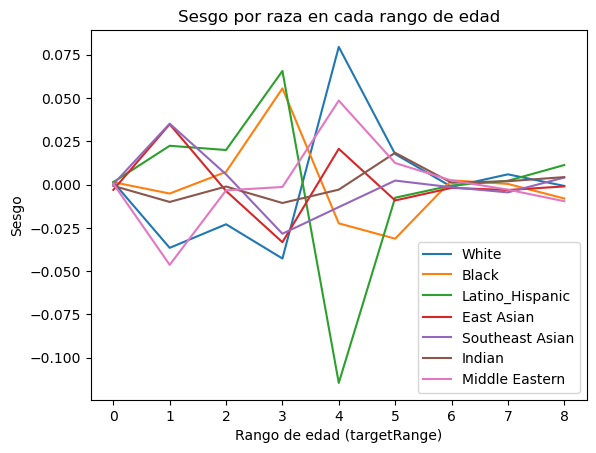

In [15]:
for i in range(7):
    df_binario = df1.copy()
    # Cambiar los valores de la columna 'race' a binario
    df_binario['race'] = df_binario['race'].apply(lambda x: 1 if x == i else 0)
    race = df_binario['race']
    
    data = pd.DataFrame({
        'y_true': df1["age"],  # Grupos de edad de 0 a 7
        'y_predict': df["age"],  # Predicciones
        'race': race,  # 0: No protegido, 1: Protegido
        'gender': df1["gender"]  # 0: Masculino, 1: Femenino
    })
    
    targetRanges = list(range(9))  # Rango de edades de 0 a 7
    biases = []

    for targetRange in targetRanges:
        bias = labelBiasMultiClass(data[['y_true', 'y_predict', 'race']].values, 
                                   data['y_predict'], 
                                   2,  # Índice de la columna protegida en la submatriz siempre es 2
                                   1,  # Valor protegido
                                   targetRange)
        biases.append(bias)
    
    plt.plot(targetRanges, biases, label=race_true[i])
    plt.xlabel('Rango de edad (targetRange)')
    plt.ylabel('Sesgo')
    plt.title('Sesgo por raza en cada rango de edad')

plt.legend()
plt.show()

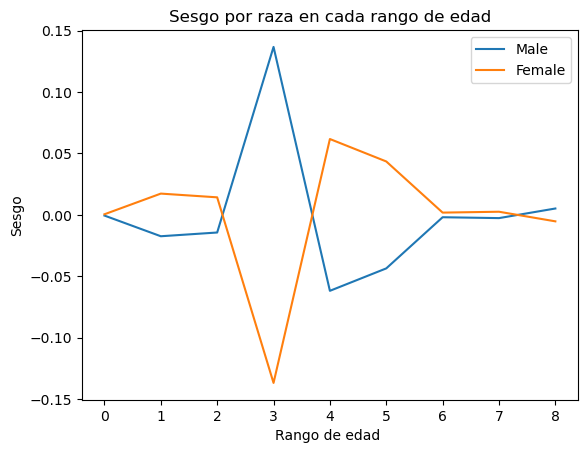

In [14]:
for i in range(2):
    
    data = pd.DataFrame({
        'y_true': df1["age"],  
        'y_predict': df["age"],  # Predicciones
        'race': race,  # 0: No protegido, 1: Protegido
        'gender': df1["gender"] 
    })
    
    targetRanges = list(range(9)) 
    biases = []

    for targetRange in targetRanges:
        bias = labelBiasMultiClass(data[['y_true', 'y_predict', 'gender']].values, 
                                   data['y_predict'], 
                                   2,  # Índice de la columna protegida en la submatriz siempre es 2
                                   i,  # Valor protegido
                                   targetRange)
        biases.append(bias)
    
    plt.plot(targetRanges, biases, label=gender_true[i])
    plt.xlabel('Rango de edad ')
    plt.ylabel('Sesgo')
    plt.title('Sesgo por raza en cada rango de edad')

plt.legend()
plt.show()

In [9]:
gender=df1['gender']
y_true=df1['age']
y_pred= df['age']


In [10]:

# Simulando los datos del modelo
# y_true son los valores verdaderos de las edades (como grupo de edad 1, 2, ..., 8)
# y_pred son las predicciones del modelo
# 'race' y 'gender' son las características sensibles, con valores binarios para simplificar

booleans=False
for i in range (7):
    a=False
    df_binario = df1.copy()
    # Cambiar los valores de la columna 'race' a binario
    df_binario['race'] = df_binario['race'].apply(lambda x: 1 if x == i else 0)
    race = df_binario['race']

    data = pd.DataFrame({
    'y_true': y_true,    # Grupos de edad de 0 a 7
    'y_pred': y_pred,
    'race': race,      # 0: No protegido, 1: Protegido
    'gender': gender   
    })

  # Cálculo del Disparate Impact Ratio para raza
    dir_race = disparate_impact_ratio(data, 'race', 'y_true', 'y_pred')
    if not (0.8 <= dir_race  and dir_race<= 1.25):
        if not a:
            print(race_true[i])
            a=True
        print(f"Posible sesgo detectado : {dir_race}")

    chi2_race, p_race = chi_square_test(data, 'race', 'y_true', 'y_pred')

    if p_race < 0.05:
        if not booleans:
            print("Un p-value menor de 0.05 da indicios de sesgos")
            booleans=True
        if not a:
            print(race_true[i])
            a=True
        print(f"Diferencia significativa en las predicciones por raza:  p-value={p_race}")

# Test de Chi-cuadrado para raza
    def chi_square_test(data, sensitive_feature, y_true_col, y_pred_col):
        
        contingency_table = pd.crosstab(data[sensitive_feature], data[y_pred_col] >= 4)
    
    # Test de Chi-cuadrado
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        return chi2, p

Un p-value menor de 0.05 da indicios de sesgos
White
Diferencia significativa en las predicciones por raza:  p-value=1.417535816319341e-15
Black
Diferencia significativa en las predicciones por raza:  p-value=3.9764546759747214e-06
Latino_Hispanic
Diferencia significativa en las predicciones por raza:  p-value=4.300187968523339e-18
Middle Eastern
Diferencia significativa en las predicciones por raza:  p-value=0.00012140895412653367


In [11]:
for i in range (2):
    df_binario = df1.copy()
    
    # Cambiar los valores de la columna 'race' a binario
    df_binario['gender'] = df_binario['gender'].apply(lambda x: 1 if x == i else 0)
    gender = df_binario['gender']
    # Mostrar el resultado de la iteración actual
    print(gender_true[i])
    data = pd.DataFrame({
    'y_true': y_true,    # Grupos de edad de 0 a 7
    'y_pred': y_pred,
    'race': race,      # 0: No protegido, 1: Protegido
    'gender': gender    
    })
# Cálculo del Disparate Impact Ratio para y género
  
    dir_gender = disparate_impact_ratio(data, 'gender', 'y_true', 'y_pred')
    if not (0.8 <= dir_gender <= 1.25):
        print(f"Posible sesgo detectado en la variable género:{dir_gender}")

# Aplicamos el test de Chi-cuadrado para raza y género
    chi2_gender, p_gender = chi_square_test(data, 'gender', 'y_true', 'y_pred')

# Evaluamos si p-value es menor que 0.05 (indicación de diferencia significativa)

    if p_gender < 0.05:
        print(f"Diferencia significativa en las predicciones por género:  p-value={p_gender}")

Male
Diferencia significativa en las predicciones por género:  p-value=1.6106584612737564e-32
Female
Diferencia significativa en las predicciones por género:  p-value=1.6106584612737564e-32
